In [1]:
import numpy as np
import scipy as sp
import scipy.sparse.linalg, scipy.optimize
from scipy.special import expit, logit, softmax
import torch

import matplotlib.pyplot as plt
%matplotlib inline
eps = 1e-8 # small real number

### Utility functions:

In [2]:
# Sample a binary adjacency matrix from a matrix of probabilities
def sample_from_expected(adj_exp, allow_diag=True):
    n, _ = adj_exp.shape
    adj_bin = np.zeros((n,n))
    if allow_diag:
        adj_bin[np.triu_indices(n)] = np.random.rand(n*(n+1)//2) < adj_exp[np.triu_indices(n)]
        adj_bin = adj_bin + adj_bin.T
        adj_bin[np.diag_indices(n)] = adj_bin[np.diag_indices(n)] // 2
    else:
        adj_bin[np.triu_indices(n,1)] = (1. * (adj_exp >= np.random.uniform(size=(n,n))))[np.triu_indices(n,1)]
        adj_bin = adj_bin + adj_bin.T
    return adj_bin

# Use SVD to get a low-rank approximation of a matrix
def get_low_rank_approx(mat, rank, return_feats=False):
    if sp.sparse.issparse(mat):
        w, v = sp.sparse.linalg.eigsh(mat.asfptype(), k=rank)
    else:
        w, v = sp.sparse.linalg.eigsh(mat.astype(np.float32), k=rank)
    if return_feats:
        return v @ np.diag(w) @ v.T, v @ np.diag(np.sqrt(np.abs(w)))
    else:
        return v @ np.diag(w) @ v.T

## Our core model and training cell:

In [3]:
def get_bc_approx(adj, B_rank, C_rank, loss_iters=100, reg_l2=0., reg_l1=0., 
                  eps=1e-8, base_logit=True, 
                  adj_mask=None,
                  return_factors=False, verbose=False):
    def bc_loss(factors, adj, n, B_rank, C_rank, base_logit, adj_mask, loss_ew_wgt):
        B = torch.tensor(factors[:n*B_rank].reshape(n, B_rank), requires_grad=True)
        C = torch.tensor(factors[n*B_rank:].reshape(n, C_rank), requires_grad=True)
        logits = base_logit + B @ B.T - C @ C.T
        logits = torch.clamp(logits, min=logit(eps), max=-logit(eps))
        if adj_mask is None:
            loss_ew = -torch.nn.functional.logsigmoid(torch.where(adj==1,+1,-1)*logits).sum() # entrywise CE loss
        else:
            loss_ew = -(adj_mask * torch.nn.functional.logsigmoid(torch.where(adj==1,+1,-1)*logits)).sum() * loss_ew_wgt
        loss_reg = 0
        if reg_l2 > 0:
            loss_reg += (B.pow(2).sum() + C.pow(2).sum()) / 2. * reg_l2
        if reg_l1 > 0:
            loss_reg += (torch.abs(B).sum() + torch.abs(C).sum()) / 2. * reg_l1
        loss = loss_ew + loss_reg
        loss.backward()
        if verbose:
            print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])
        return loss.detach().numpy(), np.concatenate((B.grad.numpy().flatten(), C.grad.numpy().flatten()))

    n = adj.shape[0]
    if base_logit: # adjusts baseline probability of edge
        base_logit = logit(adj.sum() / (n*n))
    else:
        base_logit = 0.
    factors = 1. * np.concatenate([(np.random.random(size=(n*B_rank))) / np.sqrt(B_rank),
                                   (np.random.random(size=(n*C_rank))) / np.sqrt(C_rank)])
    
    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()
    
    res = scipy.optimize.minimize(bc_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, B_rank, C_rank, base_logit, 
                                        adj_mask, loss_ew_wgt), 
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*(B_rank+C_rank),
                                  tol=np.finfo(float).eps, 
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )    
    factors = res.x
    B = res.x[:n*B_rank].reshape(n, B_rank)
    C = res.x[n*B_rank:].reshape(n, C_rank)
    logits = base_logit + B @ B.T - C @ C.T
    adj_recon = np.clip(expit(logits), a_min=eps, a_max=1.-eps)
    if return_factors:
        return adj_recon, B, C, base_logit
    else:
        return adj_recon

## Other frameworks for comparison:

In [4]:
def get_symnmf_approx(adj, rank, loss_iters=100, reg_l2=0., reg_l1=0., eps=1e-8, 
                       adj_mask=None,
                       return_factors=False, verbose=False):
    def synnmf_loss(X, adj, n, rank, adj_mask, loss_ew_wgt):
        X = torch.tensor(X.reshape(n, rank), requires_grad=True)
        adj_recon = X @ X.T
        adj_recon = torch.clamp(adj_recon, min=eps, max=1.-eps)
        if adj_mask is None:
            loss_ew = +torch.pow(adj - adj_recon,2).sum()
        else:
            loss_ew = +(adj_mask * torch.pow(adj - adj_recon,2)).sum() * loss_ew_wgt
            
        loss_reg = torch.tensor(0.)
        if reg_l2 > 0:
            loss_reg += X.pow(2).sum() * reg_l2
        if reg_l1 > 0:
            loss_reg += torch.abs(X).sum() * reg_l1
            
        loss = loss_ew + loss_reg
        loss.backward()
        if verbose:
            print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])
        return loss.detach().numpy(), X.grad.numpy().flatten()

    n = adj.shape[0]
    factors = np.random.random(size=(n*rank)) / np.sqrt(rank)

    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()

    res = scipy.optimize.minimize(synnmf_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, rank, 
                                        adj_mask, loss_ew_wgt), 
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*rank,
                                  tol=np.finfo(float).eps, 
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )    
    factors = res.x
    X = res.x.reshape(n, rank)
    adj_recon = np.clip(X @ X.T, a_min=eps, a_max=1.-eps)
    if return_factors:
        return adj_recon, X
    else:
        return adj_recon

def get_bigclam_approx(adj, rank, loss_iters=100, reg_l2=0., reg_l1=0., eps=1e-8, 
                       adj_mask=None,
                       return_factors=False, verbose=False):
    def bigclam_loss(X, adj, n, rank, adj_mask, loss_ew_wgt):
        X = torch.tensor(X.reshape(n, rank), requires_grad=True)
        adj_recon = 1. - torch.exp(-X @ X.T)
        adj_recon = torch.clamp(adj_recon, min=eps, max=1.-eps)
        
        if adj_mask is None:
            loss_ew = -torch.log(torch.where(adj==1,adj_recon,1.-adj_recon)).sum()
        else:
            loss_ew = -(adj_mask * torch.log(torch.where(adj==1,adj_recon,1.-adj_recon))).sum() * loss_ew_wgt
        
        loss_reg = torch.tensor(0.)
        if reg_l2 > 0:
            loss_reg += X.pow(2).sum() * reg_l2
        if reg_l1 > 0:
            loss_reg += torch.abs(X).sum() * reg_l1
            
        loss = loss_ew + loss_reg
        loss.backward()
        if verbose:
            print([tens.detach().numpy() for tens in [loss, loss_ew, loss_reg]])
        return loss.detach().numpy(), X.grad.numpy().flatten()

    n = adj.shape[0]
    factors = ((-np.log(1 - (adj.sum() / (n*n)))) + np.sqrt(eps)*np.random.random(size=(n*rank))) / np.sqrt(rank)

    if adj_mask is None:
        loss_ew_wgt = 1.
    else:
        loss_ew_wgt = (n**2) / adj_mask.sum()

    res = scipy.optimize.minimize(bigclam_loss, x0=factors,
                                  args=(torch.tensor(np.array(adj.todense())), n, rank, 
                                        adj_mask, loss_ew_wgt), 
                                  jac=True, method='L-BFGS-B',
                                  bounds = [(0.,None)]*n*rank,
                                  tol=np.finfo(float).eps, 
                                  options={'maxiter':loss_iters, 'ftol':np.finfo(float).eps, 'gtol':np.finfo(float).eps}
                                 )    
    factors = res.x
    X = res.x.reshape(n, rank)
    adj_recon = np.clip(1. - np.exp(-X @ X.T), a_min=eps, a_max=1.-eps)
    if return_factors:
        return adj_recon, X
    else:
        return adj_recon

## Demonstration of expressiveness using the synthetic heterophily-homophily family of graphs described in the paper:

### Creating the graph:

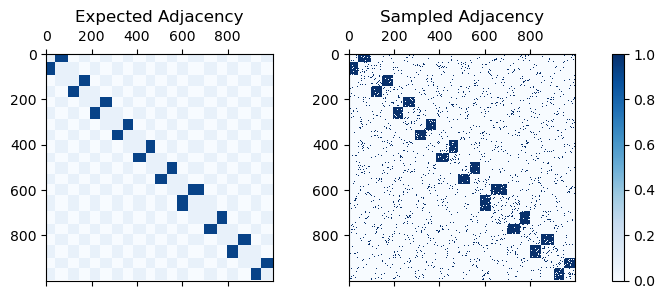

In [5]:
# Create a sample from the synthetic heterophily-homophily family of graphs described in the paper
def make_het_hom_graph(n, het_probs, hom_probs):
    num_het = len(het_probs)
    num_hom = len(hom_probs)
    U = np.zeros((n, num_het+num_hom))
    hets = np.random.choice(num_het, p=het_probs, size=n)
    homs = np.random.choice(num_hom, p=hom_probs, size=n)
    vals = homs*num_het + hets
    perm = np.argsort(vals)
    hets = hets[perm]
    homs = homs[perm]
    U[np.arange(n), homs] = 1
    U[np.arange(n), hets+num_hom] = 1
    U = np.hstack([np.ones(n)[:,None], U])
    
    W = 5*np.diag(np.concatenate(([-0.5], np.ones(num_hom), -1*np.ones(num_het))))
    return expit(U @ W @ U.T), U, W

adj_exp, feats, W = make_het_hom_graph(n=1000, het_probs=np.ones(2)/2, hom_probs=np.ones(10)/10)
adj = sample_from_expected(adj_exp)

fig, axes = plt.subplots(nrows=1, ncols=2, dpi=100, figsize=(8,3))
axes[0].matshow(adj_exp, vmin=0,vmax=1, cmap='Blues')
axes[0].set_title("Expected Adjacency")
im = axes[1].matshow(adj, vmin=0,vmax=1, cmap='Blues')
axes[1].set_title("Sampled Adjacency")
fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.06)
plt.show()

### Recreating the synthetic graph with each method and visualizing features:

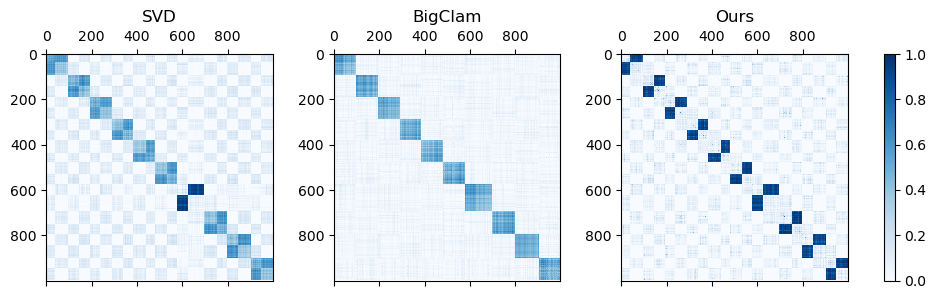

In [6]:
adj = sp.sparse.csr_matrix(adj)
tsvd_approx = np.clip(get_low_rank_approx(adj,12), a_min=eps, a_max=(1.-eps))
bigclam_approx, bigclam_feats = get_bigclam_approx(adj, 12, loss_iters=200, reg_l2=1e0, eps=1e-8, return_factors=True, verbose=False)
bc_approx, bc_B, bc_C, _  = get_bc_approx(adj, B_rank=10, C_rank=2, reg_l2=1e0, loss_iters=200, base_logit=False, return_factors=True, verbose=False)

fig, axes = plt.subplots(nrows=1, ncols=3, dpi=100, figsize=(11.5,3))
axes[0].matshow(tsvd_approx, vmin=0,vmax=1, cmap='Blues')
axes[0].set_title('SVD')
axes[1].matshow(bigclam_approx, vmin=0,vmax=1, cmap='Blues')
axes[1].set_title('BigClam')
im = axes[2].matshow(bc_approx, vmin=0,vmax=1, cmap='Blues')
axes[2].set_title('Ours')

fig.colorbar(im, ax=axes.ravel().tolist(), fraction=0.046, pad=0.04)
plt.show()

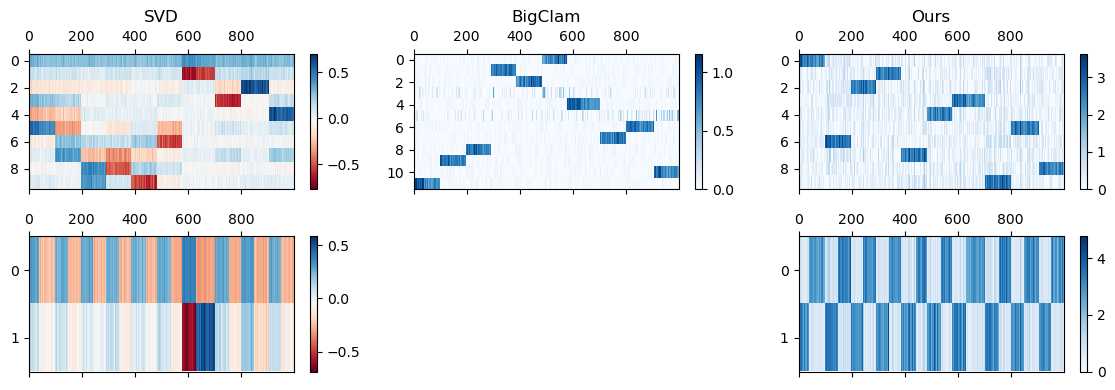

In [7]:
adj_eval, adj_evec = np.linalg.eigh(np.array(adj.todense()))
eval_order = np.argsort(-np.abs(adj_eval))[:12]
adj_eval, adj_evec = adj_eval[eval_order], adj_evec[:,eval_order]

svd_feat_B_idcs = np.where(adj_eval > 0)[0]
svd_feat_B = adj_evec[:,svd_feat_B_idcs] * np.sqrt(adj_eval[svd_feat_B_idcs])[None,:]

svd_feat_C_idcs = np.where(adj_eval < 0)[0]
svd_feat_C = adj_evec[:,svd_feat_C_idcs] * np.sqrt(-adj_eval[svd_feat_C_idcs])[None,:]

fig, axes = plt.subplots(nrows=2, ncols=3, dpi=100, figsize=(11.5,4))

im_svd_B = axes[0,0].matshow(svd_feat_B.T, aspect='auto', cmap='RdBu')
fig.colorbar(im_svd_B, ax=axes[0,0])
im_svd_C = axes[1,0].matshow(svd_feat_C.T, aspect='auto', cmap='RdBu')
fig.colorbar(im_svd_C, ax=axes[1,0])
axes[0,0].set_title('SVD')

im_bigclam = axes[0,1].matshow(bigclam_feats.T, aspect='auto', vmin=0, cmap='Blues')
fig.colorbar(im_bigclam, ax=axes[0,1])
fig.delaxes(axes[1][1])
axes[0,1].set_title('BigClam')

im_bc_B = axes[0,2].matshow(bc_B.T, aspect='auto', vmin=0, cmap='Blues')
fig.colorbar(im_bc_B, ax=axes[0,2])
im_bc_C = axes[1,2].matshow(bc_C.T, aspect='auto', vmin=0, cmap='Blues')
fig.colorbar(im_bc_C, ax=axes[1,2])
axes[0,2].set_title('Ours')

fig.tight_layout()
plt.show()

## Stochastic versions of each framework:

In [8]:
# SGD version of our framework
# unk_adj is an adjacency matrix with the same shape as adj; it is 1 where it is unknown whether the link exists 
def bc_decomp_sgd(adj, B_rank, C_rank, unk_adj=None, 
                  batch_size=100, num_iters=10000, step_size=1e-1, l2_logit_reg=1e-2, l1_logit_reg=0, verbose=False):
    edge_idcs = np.flatnonzero(adj.todense())
    unk_idcs = np.array([])
    if not unk_adj is None:
        unk_idcs = np.flatnonzero(unk_adj.todense())
        edge_idcs = np.setdiff1d(edge_idcs, unk_idcs)
            
    n = adj.shape[0]
    m = edge_idcs.shape[0]

    B = ((-1 + 2*np.random.random(size=(n*B_rank))) / np.sqrt(B_rank)).reshape(n,B_rank)
    C = ((-1 + 2*np.random.random(size=(n*C_rank))) / np.sqrt(C_rank)).reshape(n,C_rank)

    for i in range(num_iters):
        t_edge_idcs = np.random.choice(edge_idcs, size=batch_size)
        if bipartite:
            f_edge_idcs = np.setdiff1d(gen_rand_topright_idcs(n1,n2, batch_size), edge_idcs)
        else:
            f_edge_idcs = np.setdiff1d(np.random.choice(n*n, size=batch_size), edge_idcs)
        if not unk_adj is None:
            f_edge_idcs = np.setdiff1d(f_edge_idcs, unk_idcs)
            
        t_edge_idcs = np.unravel_index(t_edge_idcs, shape=(n,n))
        f_edge_idcs = np.unravel_index(f_edge_idcs, shape=(n,n))
        t_prob_wrong = expit(-(np.sum(B[t_edge_idcs[0]] * B[t_edge_idcs[1]], axis=1) - 
                               np.sum(C[t_edge_idcs[0]] * C[t_edge_idcs[1]], axis=1)))
        f_prob_wrong = expit(+(np.sum(B[f_edge_idcs[0]] * B[f_edge_idcs[1]], axis=1) - 
                               np.sum(C[f_edge_idcs[0]] * C[f_edge_idcs[1]], axis=1)))
        f_grad_reweight = len(t_edge_idcs) / len(f_edge_idcs) #* ((n*n-m)/m)
        B[t_edge_idcs[0]] += step_size * t_prob_wrong[:,None] * B[t_edge_idcs[1]]
        B[t_edge_idcs[1]] += step_size * t_prob_wrong[:,None] * B[t_edge_idcs[0]]
        C[t_edge_idcs[0]] -= step_size * t_prob_wrong[:,None] * C[t_edge_idcs[1]]
        C[t_edge_idcs[1]] -= step_size * t_prob_wrong[:,None] * C[t_edge_idcs[0]]

        B[f_edge_idcs[0]] -= step_size * f_prob_wrong[:,None] * B[f_edge_idcs[1]] * f_grad_reweight
        B[f_edge_idcs[1]] -= step_size * f_prob_wrong[:,None] * B[f_edge_idcs[0]] * f_grad_reweight
        C[f_edge_idcs[0]] += step_size * f_prob_wrong[:,None] * C[f_edge_idcs[1]] * f_grad_reweight
        C[f_edge_idcs[1]] += step_size * f_prob_wrong[:,None] * C[f_edge_idcs[0]] * f_grad_reweight

        if l2_logit_reg > 0:
            B[t_edge_idcs[0]] *= 1.-step_size*l2_logit_reg
            C[t_edge_idcs[0]] *= 1.-step_size*l2_logit_reg
            B[t_edge_idcs[1]] *= 1.-step_size*l2_logit_reg
            C[t_edge_idcs[1]] *= 1.-step_size*l2_logit_reg

            B[f_edge_idcs[0]] *= 1.-step_size*l2_logit_reg * f_grad_reweight
            C[f_edge_idcs[0]] *= 1.-step_size*l2_logit_reg * f_grad_reweight
            B[f_edge_idcs[1]] *= 1.-step_size*l2_logit_reg * f_grad_reweight
            C[f_edge_idcs[1]] *= 1.-step_size*l2_logit_reg * f_grad_reweight

        if l1_logit_reg > 0:
            B[t_edge_idcs[0]] -= step_size*l1_logit_reg
            C[t_edge_idcs[0]] -= step_size*l1_logit_reg
            B[t_edge_idcs[1]] -= step_size*l1_logit_reg
            C[t_edge_idcs[1]] -= step_size*l1_logit_reg

            B[f_edge_idcs[0]] -= step_size*l1_logit_reg * f_grad_reweight
            C[f_edge_idcs[0]] -= step_size*l1_logit_reg * f_grad_reweight
            B[f_edge_idcs[1]] -= step_size*l1_logit_reg * f_grad_reweight
            C[f_edge_idcs[1]] -= step_size*l1_logit_reg * f_grad_reweight

        B = np.maximum(0.,B)
        C = np.maximum(0.,C)
        
        if verbose:
            print("Iter: %5i\tT/F Prob Wrong: %0.4f/%0.4f" % (i, t_prob_wrong.mean(), f_prob_wrong.mean()))
        
    return B, C

In [9]:
def bigclam_decomp_sgd(adj, rank, unk_adj=None,  
                       batch_size=100, num_iters=10000, step_size=1e-1, l2_logit_reg=1e-2, l1_logit_reg=0, verbose=False):
    edge_idcs = np.flatnonzero(adj.todense())
    unk_idcs = np.array([])
    if not unk_adj is None:
        unk_idcs = np.flatnonzero(unk_adj.todense())
        edge_idcs = np.setdiff1d(edge_idcs, unk_idcs)
            
    n = adj.shape[0]
    m = edge_idcs.shape[0]

    X = ( (1. + 1e-0*np.random.random(size=(n*rank))) / np.sqrt(rank) ).reshape(n,rank)

    for i in range(num_iters):
        t_edge_idcs = np.random.choice(edge_idcs, size=batch_size)
        if bipartite:
            f_edge_idcs = np.setdiff1d(gen_rand_topright_idcs(n1,n2, batch_size), edge_idcs)
        else:
            f_edge_idcs = np.setdiff1d(np.random.choice(n*n, size=batch_size), edge_idcs)
        if not unk_adj is None:
            f_edge_idcs = np.setdiff1d(f_edge_idcs, unk_idcs)
            
        t_edge_idcs = np.unravel_index(t_edge_idcs, shape=(n,n))
        f_edge_idcs = np.unravel_index(f_edge_idcs, shape=(n,n))
        t_prob = np.maximum(1e-8, 1.-np.exp(-np.sum(X[t_edge_idcs[0]] * X[t_edge_idcs[1]], axis=1)))
        t_grad = (1.-t_prob)/t_prob
        if verbose:
            print(t_prob.mean())
            
        f_grad = -1
        f_grad_reweight = len(t_edge_idcs) / len(f_edge_idcs) #* ((n*n-m)/m)
        X[t_edge_idcs[0]] += step_size * t_grad[:,None] * X[t_edge_idcs[1]]
        X[t_edge_idcs[1]] += step_size * t_grad[:,None] * X[t_edge_idcs[0]]
        X[f_edge_idcs[0]] += step_size * f_grad * X[f_edge_idcs[1]] * f_grad_reweight
        X[f_edge_idcs[1]] += step_size * f_grad * X[f_edge_idcs[0]] * f_grad_reweight

        if l2_logit_reg > 0:
            X[t_edge_idcs[0]] *= 1.-step_size*l2_logit_reg
            X[t_edge_idcs[1]] *= 1.-step_size*l2_logit_reg
            X[f_edge_idcs[0]] *= 1.-step_size*l2_logit_reg * f_grad_reweight
            X[f_edge_idcs[1]] *= 1.-step_size*l2_logit_reg * f_grad_reweight

        if l1_logit_reg > 0:
            X[t_edge_idcs[0]] -= step_size*l1_logit_reg
            X[t_edge_idcs[1]] -= step_size*l1_logit_reg
            X[f_edge_idcs[0]] -= step_size*l1_logit_reg * f_grad_reweight
            X[f_edge_idcs[1]] -= step_size*l1_logit_reg * f_grad_reweight

        X = np.maximum(0.,X)
        
    return X

In [10]:
def symNMF_decomp_sgd(adj, rank, unk_adj=None,  
                      batch_size=100, num_iters=10000, step_size=1e-1, l2_logit_reg=1e-2, l1_logit_reg=0, verbose=False):
    edge_idcs = np.flatnonzero(adj.todense())
    unk_idcs = np.array([])
    if not unk_adj is None:
        unk_idcs = np.flatnonzero(unk_adj.todense())
        edge_idcs = np.setdiff1d(edge_idcs, unk_idcs)
            
    n = adj.shape[0]
    m = edge_idcs.shape[0]

    X = ( (1. + 1e-0*np.random.random(size=(n*rank))) / np.sqrt(rank) ).reshape(n,rank)

    for i in range(num_iters):
        t_edge_idcs = np.random.choice(edge_idcs, size=batch_size)
        if bipartite:
            f_edge_idcs = np.setdiff1d(gen_rand_topright_idcs(n1,n2, batch_size), edge_idcs)
        else:
            f_edge_idcs = np.setdiff1d(np.random.choice(n*n, size=batch_size), edge_idcs)
        if not unk_adj is None:
            f_edge_idcs = np.setdiff1d(f_edge_idcs, unk_idcs)            
        t_edge_idcs = np.unravel_index(t_edge_idcs, shape=(n,n))
        f_edge_idcs = np.unravel_index(f_edge_idcs, shape=(n,n))
        
        t_val = np.sum(X[t_edge_idcs[0]] * X[t_edge_idcs[1]], axis=1)
        f_val = np.sum(X[f_edge_idcs[0]] * X[f_edge_idcs[1]], axis=1)
        if verbose:
            print("Iter %i: Mean true/false values: %0.3f/%0.3f" % (i, t_val.mean(), f_val.mean()))
            
        f_grad_reweight = len(t_edge_idcs) / len(f_edge_idcs) #* ((n*n-m)/m)
        X[t_edge_idcs[0]] += step_size * 2*(1.-t_val)[:,None] * X[t_edge_idcs[1]]
        X[t_edge_idcs[1]] += step_size * 2*(1.-t_val)[:,None] * X[t_edge_idcs[0]]
        X[f_edge_idcs[0]] += step_size * 2*(0.-f_val)[:,None] * X[f_edge_idcs[1]] * f_grad_reweight
        X[f_edge_idcs[1]] += step_size * 2*(0.-f_val)[:,None] * X[f_edge_idcs[0]] * f_grad_reweight

        if l2_logit_reg > 0:
            X[t_edge_idcs[0]] *= 1.-step_size*l2_logit_reg
            X[t_edge_idcs[1]] *= 1.-step_size*l2_logit_reg
            X[f_edge_idcs[0]] *= 1.-step_size*l2_logit_reg * f_grad_reweight
            X[f_edge_idcs[1]] *= 1.-step_size*l2_logit_reg * f_grad_reweight

        if l1_logit_reg > 0:
            X[t_edge_idcs[0]] -= step_size*l1_logit_reg
            X[t_edge_idcs[1]] -= step_size*l1_logit_reg
            X[f_edge_idcs[0]] -= step_size*l1_logit_reg * f_grad_reweight
            X[f_edge_idcs[1]] -= step_size*l1_logit_reg * f_grad_reweight

        X = np.maximum(0.,X)
        
    return X